In [8]:
import cycler
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from pescado import mesher, poisson

### This is the most basic example of what one can do with PESCADO. We'll simply add a few gates, a charge region, and solve it for a 2D mesh.

###   We will start with a simple example where two gates are placed in space, separated by a dielectric region with zero charge.

## Initializing the PoissonProblemBuillder

    The first step is to initialize an instance of ProblemBuilder. It will create the mesh and define the Dirichlet (fixed voltage) and Neumann (fixed charge) regions.

In [18]:
pp_builder = poisson.builder.ProblemBuilder()

    After initializing it (the PoissonProblemBuillder), three operations must be performed before finalizing it and defining the Problem itself.

## 1 ) Defining the Mesh

    The most basic mesh consists of an instance of Pattern (mesher.patterns.Pattern) to which we associate an instance of Shape (mesher.shapes.Shape).
    
### Pattern
    
    A Pattern is an abstract (infinite or finite) object that defines (essentially):
        
        i) The spacing between the mesh points
        
        ii) The mesh points first neighbours
        
        iii) The local voronoi cell 
        
### Shape

    A shape is an an abstract object that defines a region in space. When called it returns True if the coordinate is inside such region and False if not.
    
### Hence the Pattern defines the mesh properties and the Shape defines the region in space where the mesh exists. 

In the next cell a simple mesh is defined, where the spacing between the points is constant.

In [19]:
pattern = mesher.patterns.Rectangular.constant(element_size=(1, 1))
shape_all = mesher.shapes.Box(lower_left=(-50, -50), size=(100, 100))

# We then proceed to add each mesh to the ProblemBuilder
pp_builder.add_sub_mesh(shape_inst=shape_all, pattern_inst=pattern)

## 2 ) Defining the Dirichlet and Neumann regions
    
    Each region in space can be defined by using an instance of Shape. Any point not set to Dirichlet is set by default as Neumann. 

In [22]:
circ_gate = mesher.shapes.Ellipsoid.hypersphere(center=(-25, -25), radius=10)
pp_builder.set_dirichlet(shape=circ_gate, setup_tag='circ')

up_gate = mesher.shapes.Box(lower_left=(-25, 20), size=(50, 10))
pp_builder.set_dirichlet(shape=up_gate, setup_tag='up')

## 3 ) Finally one needs to fix the relative permittivity 
    
    The default value is 1

In [23]:
for sh, ep in zip(
    [circ_gate | up_gate, shape_all - (circ_gate | up_gate)], [1e4, 8.1]):
    pp_builder.set_relative_permittivity(val=ep, shape_inst=sh)

## Once all three steps are finished, on can finalize the ProblemBuilder. 
## Such step initializes an instance of poisson.Problem

In [24]:
pp_problem = pp_builder.finalized(parallelize=True)

Finalizing mesh builder
Done
Constructing capacitance matrix


/home/sneto/.local/lib/python3.7/site-packages/pescado/mesher/mesh.py:782: UserWarning: Mesh continuity not tested. Change "validate_mesh" to true or use "validate_mesh_continuity" method to test it.
  'Mesh continuity not tested. Change "validate_mesh" to true '


Done
Prepare LP
Done


## The Problem

    Once the Problem is initialized, one can fix the input voltages / charges and solve the problem. Such step is done by using the SparseVector object created from the Problem instance. 
    
    There is not default value for dirichlet regions, therefore the voltage values (even 0V) must be defined at every dirichlet point
    
    The default value for Neumann regions is zero

In [25]:
volt_sv = pp_problem.sparse_vector(val=-3, shape_inst=up_gate)
volt_sv.extend(pp_problem.sparse_vector(val=0.5, shape_inst=circ_gate))

volt, charge = pp_problem.solve(voltage=volt_sv)

## Solving and recovering the voltage / charge results
    
    Once the problem is solved, the Problem instance returns two SparseVectors, one containing the voltage and the other the charge defined at each mesh point. 
    
    One can read the output SparseVectors by using the "read_sparse_vector" method in the Problem class.

In [35]:
voltage_die, idx_die = pp_problem.read_sparse_vector(
    sparse_vector_inst=volt, shape_inst=shape_all - (circ_gate | up_gate), 
    return_indices=True)

charge_gate, idx_gate = pp_problem.read_sparse_vector(
    sparse_vector_inst=charge, shape_inst=(circ_gate | up_gate), 
    return_indices=True)

    plotting

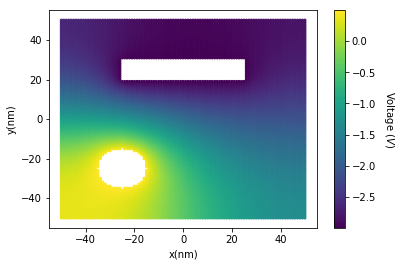

In [36]:
coordinates = pp_problem.mesh_inst.coordinates(idx_die)

normalize = mpl.colors.Normalize(vmin=voltage_die.min(), vmax=voltage_die.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(voltage_die))
   
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            c=colormap(normalize(voltage_die)), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Voltage $(V)$', rotation=270, labelpad=20)

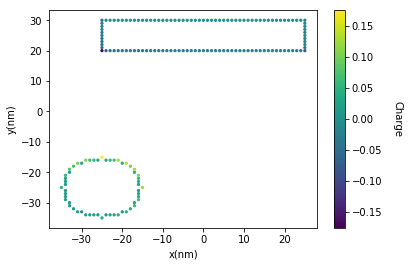

In [37]:
non_zero = charge_gate != 0.0

coordinates = pp_problem.mesh_inst.coordinates(idx_gate)

normalize = mpl.colors.Normalize(vmin=charge_gate.min(), vmax=charge_gate.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(charge_gate))
   
plt.scatter(coordinates[non_zero, 0], coordinates[non_zero, 1],
            c=colormap(normalize(charge_gate[non_zero])), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Charge', rotation=270, labelpad=20)

###    One can add a dopant region to the dielectric (this can be done directly to the Problem object)

In [46]:
dopant = mesher.shapes.Box(lower_left=(-5, -10), size=(10, 20))

charge_sv = pp_problem.sparse_vector(
    val=-10e15*1e-18, shape_inst=dopant, density_to_charge=True)

volt, charge = pp_problem.solve(voltage=volt_sv, charge_electrons=charge_sv)

In [52]:
voltage_die, idx_die = pp_problem.read_sparse_vector(
    sparse_vector_inst=volt, shape_inst=shape_all - (circ_gate | up_gate), 
    return_indices=True)

charge_die = pp_problem.read_sparse_vector(
    sparse_vector_inst=charge, shape_inst=shape_all - (circ_gate | up_gate))

charge_gate, idx_gate = pp_problem.read_sparse_vector(
    sparse_vector_inst=charge, shape_inst=(circ_gate | up_gate), 
    return_indices=True)

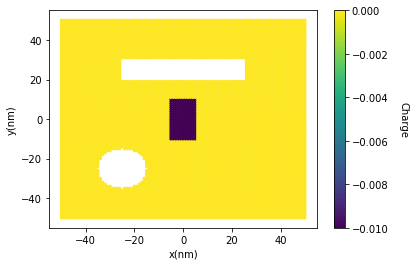

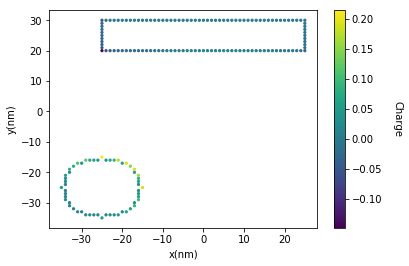

In [53]:
coordinates = pp_problem.mesh_inst.coordinates(idx_die)

normalize = mpl.colors.Normalize(vmin=voltage_die.min(), vmax=voltage_die.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(voltage_die))
   
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            c=colormap(normalize(voltage_die)), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Voltage $(V)$', rotation=270, labelpad=20)

plt.show()

normalize = mpl.colors.Normalize(vmin=charge_die.min(), vmax=charge_die.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(charge_die))
   
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            c=colormap(normalize(charge_die)), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Charge', rotation=270, labelpad=20)

plt.show()

non_zero = charge_gate != 0.0

coordinates = pp_problem.mesh_inst.coordinates(idx_gate)

normalize = mpl.colors.Normalize(vmin=charge_gate.min(), vmax=charge_gate.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(charge_gate))
   
plt.scatter(coordinates[non_zero, 0], coordinates[non_zero, 1],
            c=colormap(normalize(charge_gate[non_zero])), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Charge', rotation=270, labelpad=20)

### One can add another gate, with a more comple shape

In [54]:
side_gate = (mesher.shapes.Box(lower_left=(15, -25), size=(30, 25))
             - mesher.shapes.Ellipsoid.hypersphere(center=(25, -25), radius=10))

In [63]:
pp_builder.reset_regions() # Reset the Dirichlet / Neumann regions

pp_builder.set_dirichlet(shape=side_gate, setup_tag='side_gate')
pp_builder.set_dirichlet(shape=circ_gate, setup_tag='circ')
pp_builder.set_dirichlet(shape=up_gate, setup_tag='up')


###    Here another instance of Problem is initialized using the same instance of ProblemBuilder, but with different boundary conditions

In [58]:
pp_problem_2 = pp_builder.finalized(parallelize=True)

Finalizing mesh builder
Done
Constructing capacitance matrix


/home/sneto/.local/lib/python3.7/site-packages/pescado/mesher/mesh.py:782: UserWarning: Mesh continuity not tested. Change "validate_mesh" to true or use "validate_mesh_continuity" method to test it.
  'Mesh continuity not tested. Change "validate_mesh" to true '


Done
Prepare LP
Done


In [59]:
volt_sv = pp_problem.sparse_vector(val=-3, shape_inst=up_gate)
for v, sh in zip([2, 0.5], [side_gate, circ_gate]):
    volt_sv.extend(pp_problem.sparse_vector(val=v, shape_inst=sh))
    
charge_sv = pp_problem.sparse_vector(
    val=1e15*1e-18, shape_inst=dopant, density_to_charge=True)

volt, charge = pp_problem.solve(voltage=volt_sv, charge_electrons=charge_sv)

In [61]:
voltage_die, idx_die = pp_problem.read_sparse_vector(
    sparse_vector_inst=volt, shape_inst=shape_all - (circ_gate | up_gate | side_gate), 
    return_indices=True)

charge_die = pp_problem.read_sparse_vector(
    sparse_vector_inst=charge, shape_inst=shape_all - (circ_gate | up_gate | side_gate))

charge_gate, idx_gate = pp_problem.read_sparse_vector(
    sparse_vector_inst=charge, shape_inst=(circ_gate | up_gate | side_gate), 
    return_indices=True)

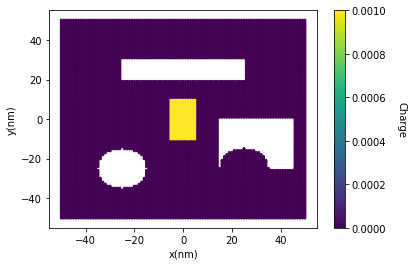

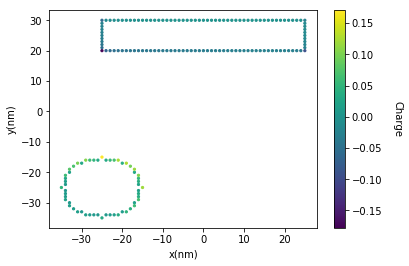

In [62]:
coordinates = pp_problem.mesh_inst.coordinates(idx_die)

normalize = mpl.colors.Normalize(vmin=voltage_die.min(), vmax=voltage_die.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(voltage_die))
   
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            c=colormap(normalize(voltage_die)), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Voltage $(V)$', rotation=270, labelpad=20)

plt.show()

normalize = mpl.colors.Normalize(vmin=charge_die.min(), vmax=charge_die.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(charge_die))
   
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            c=colormap(normalize(charge_die)), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Charge', rotation=270, labelpad=20)

plt.show()

non_zero = charge_gate != 0.0

coordinates = pp_problem.mesh_inst.coordinates(idx_gate)

normalize = mpl.colors.Normalize(vmin=charge_gate.min(), vmax=charge_gate.max())
colormap = plt.cm.viridis
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(len(charge_gate))
   
plt.scatter(coordinates[non_zero, 0], coordinates[non_zero, 1],
            c=colormap(normalize(charge_gate[non_zero])), s=5)

plt.ylabel('y(nm)')
plt.xlabel('x(nm)')
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(r'Charge', rotation=270, labelpad=20)